<a href="https://colab.research.google.com/github/RyosukeHanaoka/TechTeacher/blob/main/Semantic_hand_segmentation2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Pytorch を使用した、手のセマンティックセグメンテーション
セマンティック セグメンテーションは、画像内の各ピクセルのクラスを予測するタスクです。この問題は、オブジェクトの周囲のボックスを予測する必要があるオブジェクト検出よりも困難です。これは、各ピクセルのクラスを予測するだけでなく、同じクラスの複数のインスタンスを区別する必要があるインスタンス セグメンテーションよりもわずかに簡単です。下の図は、取得しようとしている結果を示しています。

ここでは、Pytorch とその事前定義モデルを使用して、手早く簡単に手のセグメンテーション ソフトウェアを立ち上げて実行してみます。

独自のニューラル ネットワークを設計するのではなく、Pytorch のモデル リポジトリからResnet50 バックボーンを備えた DeepLabv3を使用します。次に、EGO Hands[2]、GTEA[3]、Hand over Face[1]データセットで構成される結合データセットでモデルをトレーニングします。これは、約 28,000 個の画像とそのセグメンテーション マスク (2.1 GB のデータ) を構成します。最後に、OpenCV を使用してリアルタイムで手をセグメント化するモデルを使用するいくつかの関数を作成します。

##モデル
最初のステップは、Pytorch のリポジトリからモデルを取得することです。これは非常に簡単です。

In [1]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [17]:
import pandas as pd
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.transforms import functional
from tqdm.notebook import tqdm

In [43]:
import torch.nn as nn
from torchvision import models
import torchvision.models as models

# モデルのロード
#model = models.segmentation.deeplabv3_resnet50(pretrained=False)  # 事前学習を使わない場合
#model.classifier[4] = torch.nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1))  # 最後の層のチャンネル数を2に変更

deeplab = models.segmentation.deeplabv3_resnet50(pretrained=0,
                                                 progress=1,
                                                 num_classes=2)

ここでは、torchvision のモデル モジュールを使用してdeeplabv3_resnet50モデルを取得します。2 つのグレースケール画像を生成するため、クラスの数をnum_classes2 として指定します。1 つは手のある領域を予測するため、もう 1 つは手のない領域を予測するためです。グレースケール画像は入力画像と同じサイズになります。これら 2 つの予測を比較して、モデルが画像の各ピクセルでハンドの可能性が高いか、ハンドが存在しないかを予測するかを確認します。

次に、データを処理するためのカスタム モデルを作成します。

In [44]:
class HandSegModel(nn.Module):
    def __init__(self):
        super(HandSegModel,self).__init__()
        self.dl = deeplab

    def forward(self, x):
        y = self.dl(x)['out']
        return y

モデルに関して行うべきことはこれだけです。

##データ、データセット、データローダー
次に、データを取得する必要があります。このリンクからデータを取得できます。フォルダーには 3 つのデータセットがあります。使用するデータセットのフォルダーを、Python コードを実行するフォルダーに配置する必要があります。あるいは、独自のデータセットを使用することもできます。😅

データセットを作成し、Pytorch のデータローダーを使用してデータセットからバッチをフェッチします。これがカスタム データセットです。

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


上記にData augmentationを追加したものを以下に添付

In [45]:
import glob
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset

class SegDataset(Dataset):

    def __init__(self, parentDir, imageDir, maskDir, augment=False):
        self.imageList = glob.glob(parentDir+'/'+imageDir+'/*')
        self.imageList.sort()
        self.maskList = glob.glob(parentDir+'/'+maskDir+'/*')
        self.maskList.sort()
        self.augment = augment

    def __getitem__(self, index):

        if self.augment:
            # Data Augmentation
            augmentation = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),  # 10 degrees rotation
                transforms.ColorJitter(brightness=0.1, contrast=0.1)
            ])
        else:
            augmentation = transforms.Compose([])

        preprocess = transforms.Compose([
            transforms.Resize((384, 288), 2),
            augmentation,  # Data Augmentation step added here
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        X = Image.open(self.imageList[index]).convert('RGB')
        X = preprocess(X)

        mask_preprocess = transforms.Compose([
            transforms.Resize((384, 288), 2),
            augmentation  # Data Augmentation step added here
        ])

        yimg = Image.open(self.maskList[index]).convert('L')
        yimg = mask_preprocess(yimg)
        y1 = transforms.ToTensor()(yimg)
        y1 = y1.type(torch.BoolTensor)
        y2 = torch.bitwise_not(y1)
        y = torch.cat([y2, y1], dim=0)

        return X, y

    def __len__(self):
        return len(self.imageList)

マスクと画像が別のフォルダーにあり、それらのフォルダーが同じ親フォルダーにあると仮定します。
コンストラクターは 3 つの引数を取ります。

parentDir: イメージおよびマスク フォルダーが配置される親フォルダーの名前。
imageDir: 画像が配置されているフォルダー。
MaskDir: セグメンテーション マスクが配置されているフォルダー。
クラスのコンストラクターで、SegDatasetイメージとマスクのファイル名のリストを取得します。この__getitem__ 関数では、画像とマスクの両方を取得します。画像のサイズを変更して標準化し、X を取得します。ラベルでもあるマスクについては、画像のサイズを変更して標準化します。その後、__bitwisenot__マスクに操作を適用して、元のマスクの正確なネガである別のマスクを取得します。次に、これら 2 つのマスクをスタックして 2 チャネル イメージを取得します。最初のチャネルはハンド ラベルに対応し、2 番目のチャネルはノーハンド ラベルに対応します。

複数のデータセットを 1 つに結合する必要があります。これが私がやった方法です。

In [46]:
dataset_path = '/content/drive/MyDrive/healthy_right_hand/'
healthy_right_hand_Images = SegDataset(dataset_path, 'Images', 'Masks')

In [8]:
#dataset_path = '/content/drive/MyDrive/hand2K_dataset/GTEA'
#GTEA_Images = SegDataset(dataset_path, 'Images', 'Masks')
#GTEA_oldImages = SegDataset(dataset_path, 'oldImages', 'oldMasks')

In [9]:
from torch.utils.data import ConcatDataset

#dataset_path = '/content/drive/MyDrive/hand2K_dataset/GTEA_GAZE_PLUS'
#sub_dirs = ['ahmad_burger', 'ahmad_greek', 'ahmad_snack', 'alireaza_american', 'alireza_burger', 'alireza_greek', 'carlos_pasta', 'carlos_pizza', 'carlos_turkey', 'rahul_american', 'rahul_snack', 'rahul_turkey', 'shaghayegh_american', 'shaghayegh_snack', 'yin_pasta', 'yin_pizza']

#datasets = []
#for sub_dir in sub_dirs:
    #image_dir = f'Images/{sub_dir}'
    #mask_dir = f'Masks/{sub_dir}'
    #datasets.append(SegDataset(dataset_path, image_dir, mask_dir))

#GTEA_GAZE_PLUS_Dataset = ConcatDataset(datasets)

In [10]:
#megaDataset = ConcatDataset([GTEA_Images, GTEA_oldImages, GTEA_GAZE_PLUS_Dataset ])

それぞれに対して SegDataset を作成し、それらを .html として結合します→megaDataset 💪。

次に、データセットを分割し、トレーニング データセットと検証データセット用に 2 つのデータローダーを作成します。

In [47]:
from torch.utils.data import DataLoader

#TTR is Train Test Ratio
def trainTestSplit(dataset, TTR):
    trainDataset = torch.utils.data.Subset(dataset, range(0, int(TTR * len(dataset))))
    valDataset = torch.utils.data.Subset(dataset, range(int(TTR*len(dataset)), len(dataset)))
    return trainDataset, valDataset

batchSize = 2
trainDataset, valDataset = trainTestSplit(healthy_right_hand_Images, 0.8)
trainLoader = DataLoader(trainDataset, batch_size = batchSize, shuffle=True, drop_last=True)
valLoader = DataLoader(valDataset, batch_size = batchSize, shuffle=True, drop_last=True)

ピクセル精度は、正しく予測されたピクセルの数をピクセルの総数で割ったものです。

##パフォーマンス指標
モデルとデータローダーの準備ができたので、トレーニング プロセスを追跡するためにいくつかのパフォーマンス メトリクスを作成します。

このタスクのメトリクスとして、Intersection over UnionとPixel Accuracyを使用します。IOU は、セグメンテーション タスクの標準メトリックです。予測とターゲットの交差面積をそれらの結合で割った値が得られます。直観的には、正しく予測された領域の面積を関連する合計面積で割ったものと考えることができます。数値的には、0.5 を超える IOU 値が適切です。遠ければ遠いほど良いです。

In [48]:
def meanIOU(target, predicted):
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return

    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return

    iousum = 0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)

        intersection = np.logical_and(target_arr, predicted_arr).sum()
        union = np.logical_or(target_arr, predicted_arr).sum()
        if union == 0:
            iou_score = 0
        else :
            iou_score = intersection / union
        iousum +=iou_score

    miou = iousum/target.shape[0]
    return miou

ピクセル精度は、正しく予測されたピクセルの数をピクセルの総数で割ったものです。

In [49]:
def pixelAcc(target, predicted):
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return

    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return

    accsum=0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)

        same = (target_arr == predicted_arr).sum()
        a, b = target_arr.shape
        total = a*b
        accsum += same/total

    pixelAccuracy = accsum/target.shape[0]
    return pixelAccuracy

##トレーニング
さて、私たち全員が待ち望んでいたトレーニングの瞬間です。

まず、適切なハイパーパラメータを使用して、オプティマイザと損失関数、モデル、学習率スケジューラ オブジェクトを作成します。

In [50]:
model = HandSegModel()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
loss_fn = nn.BCEWithLogitsLoss ()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)

In [26]:
!ls -l

total 12
drwxr-xr-x 2 root root 4096 Oct  9 13:43 checkpoints
drwx------ 6 root root 4096 Oct  9 13:41 drive
drwxr-xr-x 1 root root 4096 Oct  5 19:33 sample_data


次に、作成されたすべてのオブジェクトを引数として受け取り、モデルをトレーニングするトレーニング ループ関数を作成します。

In [51]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader, lastCkptPath = None):
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    device = torch.device(dev)

    tr_loss_arr = []
    val_loss_arr = []
    meanioutrain = []
    pixelacctrain = []
    meanioutest = []
    pixelacctest = []
    prevEpoch = 0

    if lastCkptPath != None :
        checkpoint = torch.load(lastCkptPath)
        prevEpoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])

        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
                    tr_loss_arr =  checkpoint['Training Loss']
        val_loss_arr =  checkpoint['Validation Loss']
        meanioutrain =  checkpoint['MeanIOU train']
        pixelacctrain =  checkpoint['PixelAcc train']
        meanioutest =  checkpoint['MeanIOU test']
        pixelacctest =  checkpoint['PixelAcc test']
        print("loaded model, ", checkpoint['description'], "at epoch", prevEpoch)
        model.to(device)

    for epoch in range(0, n_epochs):
        train_loss = 0.0
        pixelacc = 0
        meaniou = 0

        pbar = tqdm(train_loader, total = len(train_loader))
        for X, y in pbar:
            torch.cuda.empty_cache()
            model.train()
            X = X.to(device).float()
            y = y.to(device).float()
            ypred = model(X)
            loss = loss_fn(ypred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tr_loss_arr.append(loss.item())
            meanioutrain.append(meanIOU(y, ypred))
            pixelacctrain.append(pixelAcc(y, ypred))
            pbar.set_postfix({'Epoch':epoch+1+prevEpoch,
                              'Training Loss': np.mean(tr_loss_arr),
                              'Mean IOU': np.mean(meanioutrain),
                              'Pixel Acc': np.mean(pixelacctrain)
                             })

        with torch.no_grad():

            val_loss = 0
            pbar = tqdm(val_loader, total = len(val_loader))
            for X, y in pbar:
                torch.cuda.empty_cache()
                X = X.to(device).float()
                y = y.to(device).float()
                model.eval()
                ypred = model(X)

                val_loss_arr.append(loss_fn(ypred, y).item())
                pixelacctest.append(pixelAcc(y, ypred))
                meanioutest.append(meanIOU(y, ypred))

                pbar.set_postfix({'Epoch':epoch+1+prevEpoch,
                                  'Validation Loss': np.mean(val_loss_arr),
                                  'Mean IOU': np.mean(meanioutest),
                                  'Pixel Acc': np.mean(pixelacctest)
                                 })



        checkpoint = {
            'epoch':epoch+1+prevEpoch,
            'description':"add your description",
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training Loss': tr_loss_arr,
            'Validation Loss':val_loss_arr,
            'MeanIOU train':meanioutrain,
            'PixelAcc train':pixelacctrain,
            'MeanIOU test':meanioutest,
            'PixelAcc test':pixelacctest
        }
        torch.save(checkpoint, 'checkpoints/checkpointhandseg'+str(epoch+1+prevEpoch)+'.pt')
        lr_scheduler.step()

    return tr_loss_arr, val_loss_arr, meanioutrain, pixelacctrain, meanioutest, pixelacctest

In [14]:
!mkdir checkpoints

In [52]:
retval = training_loop(30,
                       optimizer,
                       lr_scheduler,
                       model,
                       loss_fn,
                       trainLoader,
                       valLoader,
                       lastCkptPath=None)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

トレーニング中の平均損失とパフォーマンス メトリクスが表示されます。エポックごとに、これまでに計算されたすべての損失とメトリクスを含むチェックポイントが保存されます。これにより、いつでもトレーニングを停止し、データを失うことなく再開できるようになります。この関数の最後の引数は、トレーニングを再開するチェックポイントへのパスです。この関数は、トレーニングからのすべての重要なデータ、つまりトレーニングおよび検証データセット上の損失とメトリクスのタプルを返します。

まず、トレーニング ループを実行します。

In [19]:
#call the training loop,
#make sure to pass correct checkpoint path, or none if starting with the training
#retval = training_loop(3,
                       #optimizer,
                       #lr_scheduler,
                       #model,
                       #loss_fn,
                       #trainLoader,
                       #valLoader,
                       #'checkpoints/checkpointhandseg.pt')

データをプロットするには、リストの移動平均を使用できます。

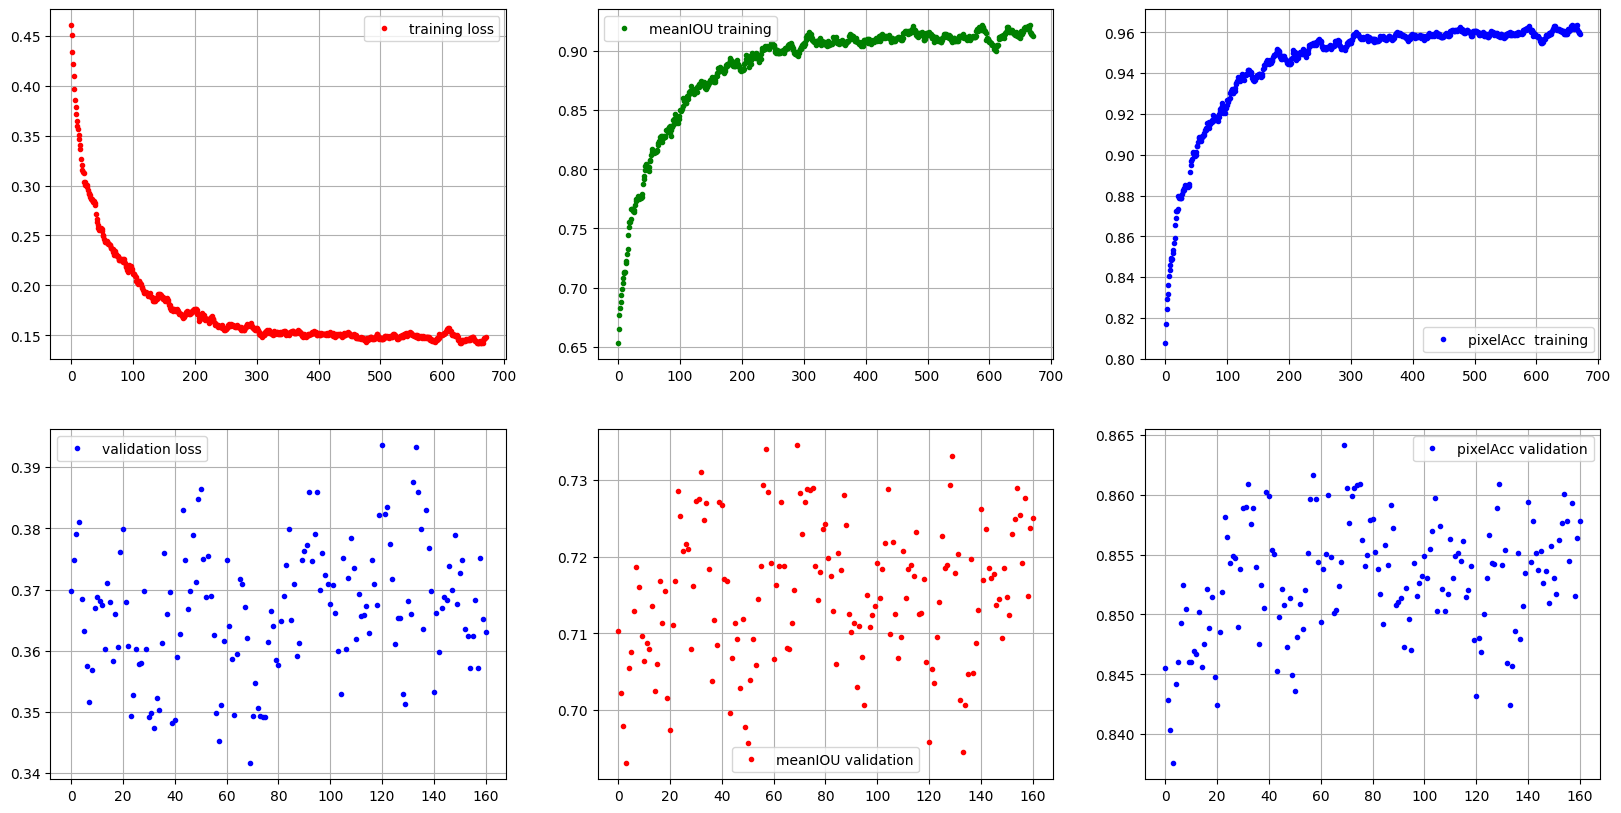

In [53]:
#after the training loop returns, we can plot the data
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)
adjusted_N = min([len(item) for item in retval]) // 4
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = (20,10))
N = 20
ax[0][0].plot(running_mean(retval[0], N), 'r.', label='training loss')
ax[1][0].plot(running_mean(retval[1], N), 'b.', label='validation loss')
ax[0][1].plot(running_mean(retval[2], N), 'g.', label='meanIOU training')
ax[1][1].plot(running_mean(retval[4], N), 'r.', label='meanIOU validation')
ax[0][2].plot(running_mean(retval[3], N), 'b.', label='pixelAcc  training')
ax[1][2].plot(running_mean(retval[5], N), 'b.', label='pixelAcc validation')
for i in ax:
    for j in i:
        j.legend()
        j.grid(True)
plt.show()

N 値を少し調整して、より滑らかな、またはよりノイズの多いプロットを取得してみることができます。

##リアルタイムの手のセグメンテーション
私たちは自分たちの努力の結果を見る準備ができています。OpenCV を使用してカメラからフレームを読み取り、フレームのセグメンテーション マスクを予測します。

まず、モデルから予測を取得するためのヘルパー関数をいくつか作成します。

In [21]:
#can pass np array or path to image file
def SegmentHands(pathtest):

    if isinstance(pathtest, np.ndarray):
        img = Image.fromarray(pathtest)
    else :
        img = Image.open(pathtest)

    preprocess = transforms.Compose([transforms.Resize((288, 384), 2),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    Xtest = preprocess(img)

    checkpoint = torch.load('checkpoints/checkpointhandseg7.pt')
    model = HandSegModel()
    model.load_state_dict(checkpoint['state_dict'])
    with torch.no_grad():
        model.eval()
        if torch.cuda.is_available():
            dev = "cuda:0"
        else:
            dev = "cpu"
        device = torch.device(dev)
        model.to(device)
        Xtest = Xtest.to(device).float()
        ytest = model(Xtest.unsqueeze(0).float())
        ypos = ytest[0, 1, :, :].clone().detach().cpu().numpy()
        yneg = ytest[0, 0, :, :].clone().detach().cpu().numpy()
        ytest = ypos >= yneg

    mask = ytest.astype('float32')
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask = cv2.dilate(mask,kernel,iterations = 2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

この関数はバイナリマスクを出力します。入力として画像の numpy 配列または画像のパスを受け取ります。画像に閉じる操作と開く操作を適用して、ノイズを軽減し、マスクを少し拡張します。

次に、画像内の手の領域に重み付けされた緑色のマスクを追加する関数がいくつかあります。

In [22]:
def getcoloredMask(image, mask):
    color_mask = np.zeros_like(image)
    color_mask[:, :, 1] += mask.astype('uint8') * 250
    masked = cv2.addWeighted(image, 1.0, color_mask, 1.0, 0.0)
    return masked

最後に、OpenCV を使用してカメラから画像を読み取り、画像内の手の領域を予測します。

In [23]:
cap = cv2.VideoCapture(0)
i = 0
while(True):
    ret, frame = cap.read()

    frame = cv2.resize(frame, (384,288))
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if i%5 == 0:
        i=0
        mask = SegmentHands(rgb)
        colmask = getcoloredMask(frame, mask)

    cv2.imshow('color', np.hstack((frame, colmask)))
    key = cv2.waitKey(24)
    if key & 0xFF == ord('q'):
        break
    i+=1
cap.release()
cv2.destroyAllWindows()

error: ignored

##その他に試してみること:

データ拡張（ランダム クロッピング、スケーリング、ノイズ追加など）を使用します。
別のモデル アーキテクチャを使用する
より大きな、またはより強力なデータセットを使用する
ハイパーパラメータを調整する